In [23]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st
import dynamo as dyn
import cv2
import anndata
import pandas as pd
from scipy import stats

import scanpy as sc

plt.style.use('default')
plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mtx_path = "matrix.txt.gz"
tif_path = "ssDNA.tif"
seg_path = "full_segmentation.h5ad"

In [3]:
segmentation_adata = anndata.read(seg_path)
segmentation_adata

AnnData object with n_obs × n_vars = 10509 × 13646
    uns: '__type', 'spatial'
    layers: 'X_bins', 'X_labels', 'X_labels_expanded', 'X_mask', 'X_scores', 'cell_labels', 'cell_labels_expanded', 'nuclear', 'nuclear_labels', 'nuclear_mask', 'nuclear_scores', 'spliced', 'stain', 'stain_cell_mask', 'stain_labels', 'stain_markers', 'stain_mask', 'unspliced', 'unspliced_bins', 'unspliced_labels', 'unspliced_mask', 'unspliced_scores'

In [30]:
%%time
adata = st.io.read_bgi(
    mtx_path,
    segmentation_adata=segmentation_adata,
    labels_layer='cell_labels_expanded'
)
adata = st.io.read_image(adata=adata,filename=tif_path,img_layer="mouse_brain",slice="ssdna",scale_factor=1)
adata.write('adata_cell_labels.h5ad', compression='gzip')

|-----> <select> cell_labels_expanded layer in AnnData Object
|-----> Using labels provided with `segmentation_adata` and `labels_layer` arguments.
|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.
CPU times: user 1min 57s, sys: 9.87 s, total: 2min 7s
Wall time: 2min 6s


In [31]:
adata = anndata.read('adata_cell_labels.h5ad')

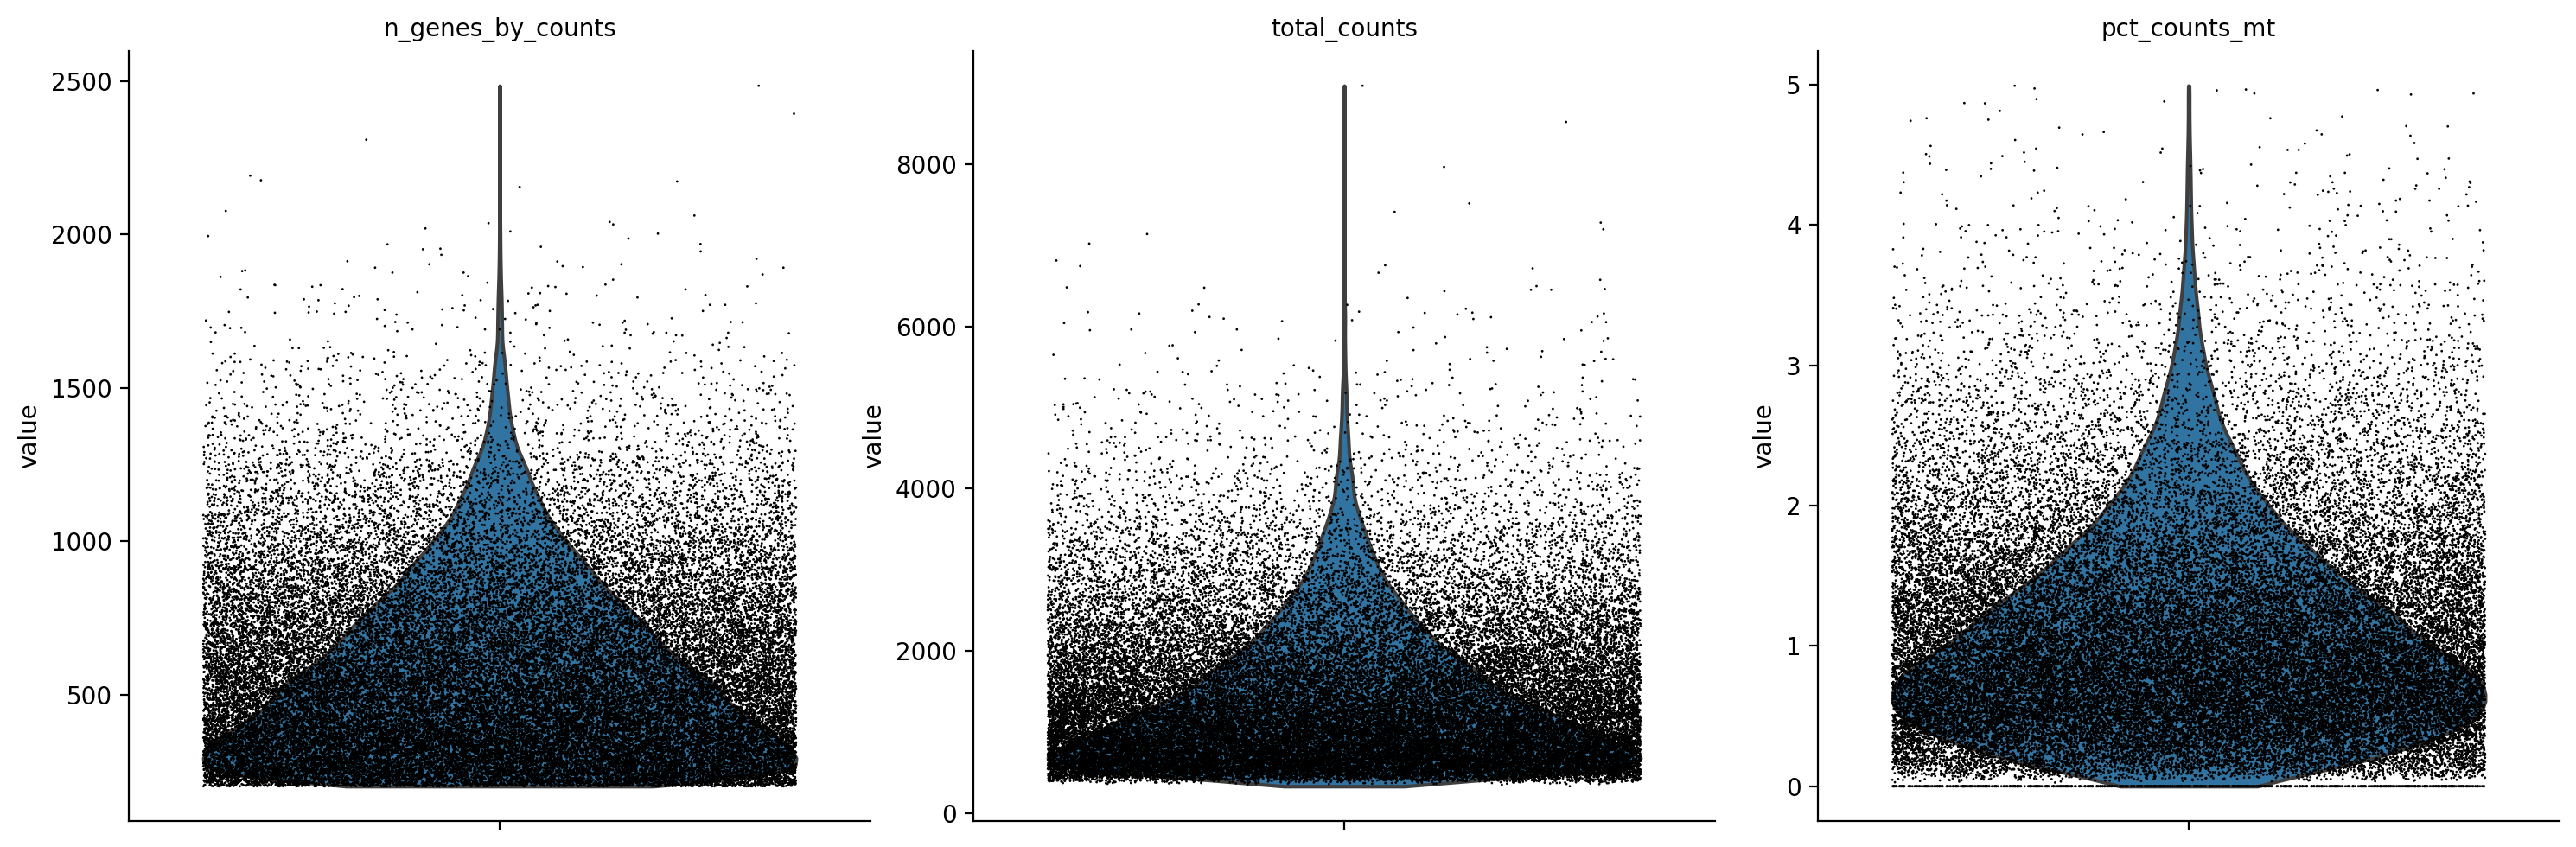

View of AnnData object with n_obs × n_vars = 46720 × 26274
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'spatial'
    obsm: 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [6]:
# QC
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
adata

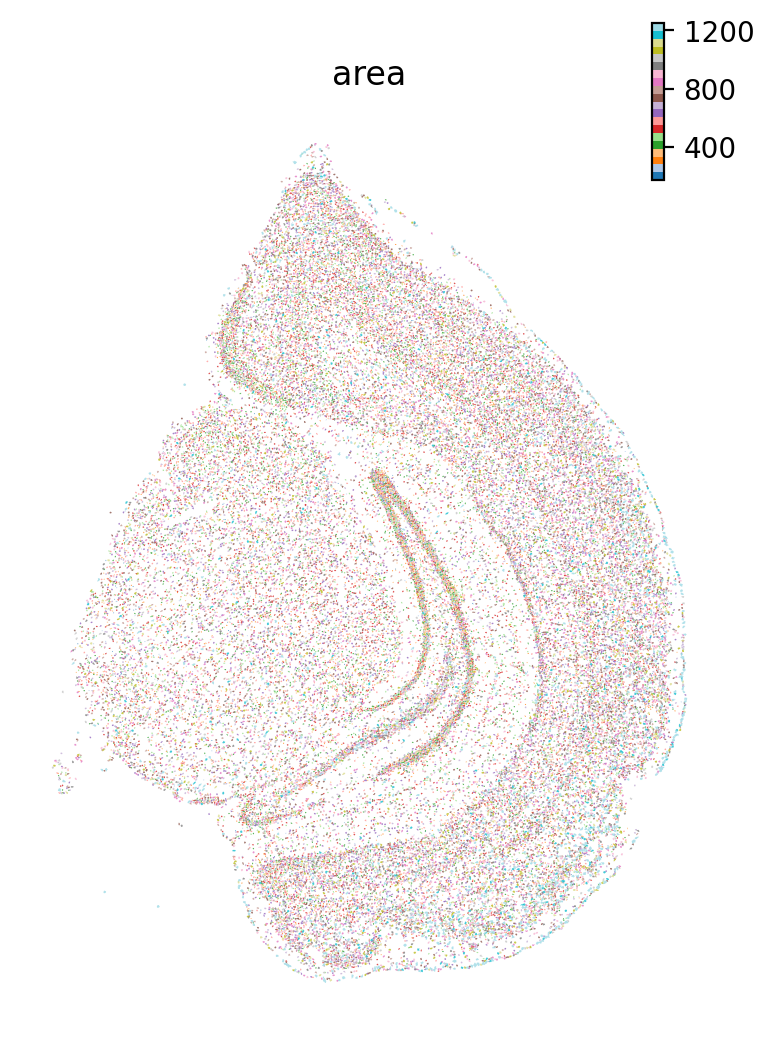

In [7]:
st.pl.geo(adata, color=['area'], boundary_width=0, show_legend="upper left", cmap="tab20")

In [8]:
# Preprocessing
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.uns["pp"] = {}
adata.var_names_make_unique()
st.pp.filter.filter_genes(adata, min_cells=3)

AnnData object with n_obs × n_vars = 46720 × 22842
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'pass_basic_filter'
    uns: '__type', 'spatial', 'pp'
    obsm: 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [9]:
st.tl.sctransform(adata,rlib_path='/Users/jingzehua/opt/anaconda3/envs/spateo/lib/R', n_top_genes=adata.n_vars)
adata

AnnData object with n_obs × n_vars = 46720 × 26274
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'spatial', 'pp'
    obsm: 'bbox', 'contour', 'spatial', 'pearson_residuals'
    layers: 'spliced', 'unspliced'

In [ ]:
#besca.pp.scTransform(adata, n_genes=3000, rlib_loc='/Users/jingzehua/opt/anaconda3/envs/spateo/lib/R/library')

In [10]:
st.tl.pca_spateo(adata, n_pca_components=50, X_data = adata.obsm['pearson_residuals'])
adata

|-----> Runing PCA on obsm[pearson_residuals]...


AnnData object with n_obs × n_vars = 46720 × 26274
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'spatial', 'pp'
    obsm: 'bbox', 'contour', 'spatial', 'pearson_residuals', 'X_pca'
    layers: 'spliced', 'unspliced'

In [11]:
dyn.tl.neighbors(adata, n_neighbors=30)
adata

|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.


AnnData object with n_obs × n_vars = 46720 × 26274
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'spatial', 'pp', 'neighbors'
    obsm: 'bbox', 'contour', 'spatial', 'pearson_residuals', 'X_pca'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Detecting communities on graph...
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'graph_tool', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}
|-----------> Converting graph_sparse_matrix to networkx object
|-----> Detecting community with initial_membership input from caller
|-----> [Community clustering with leiden] in progress: 100.0000%
|-----> [Community clustering with leiden] finished [632.2598s]


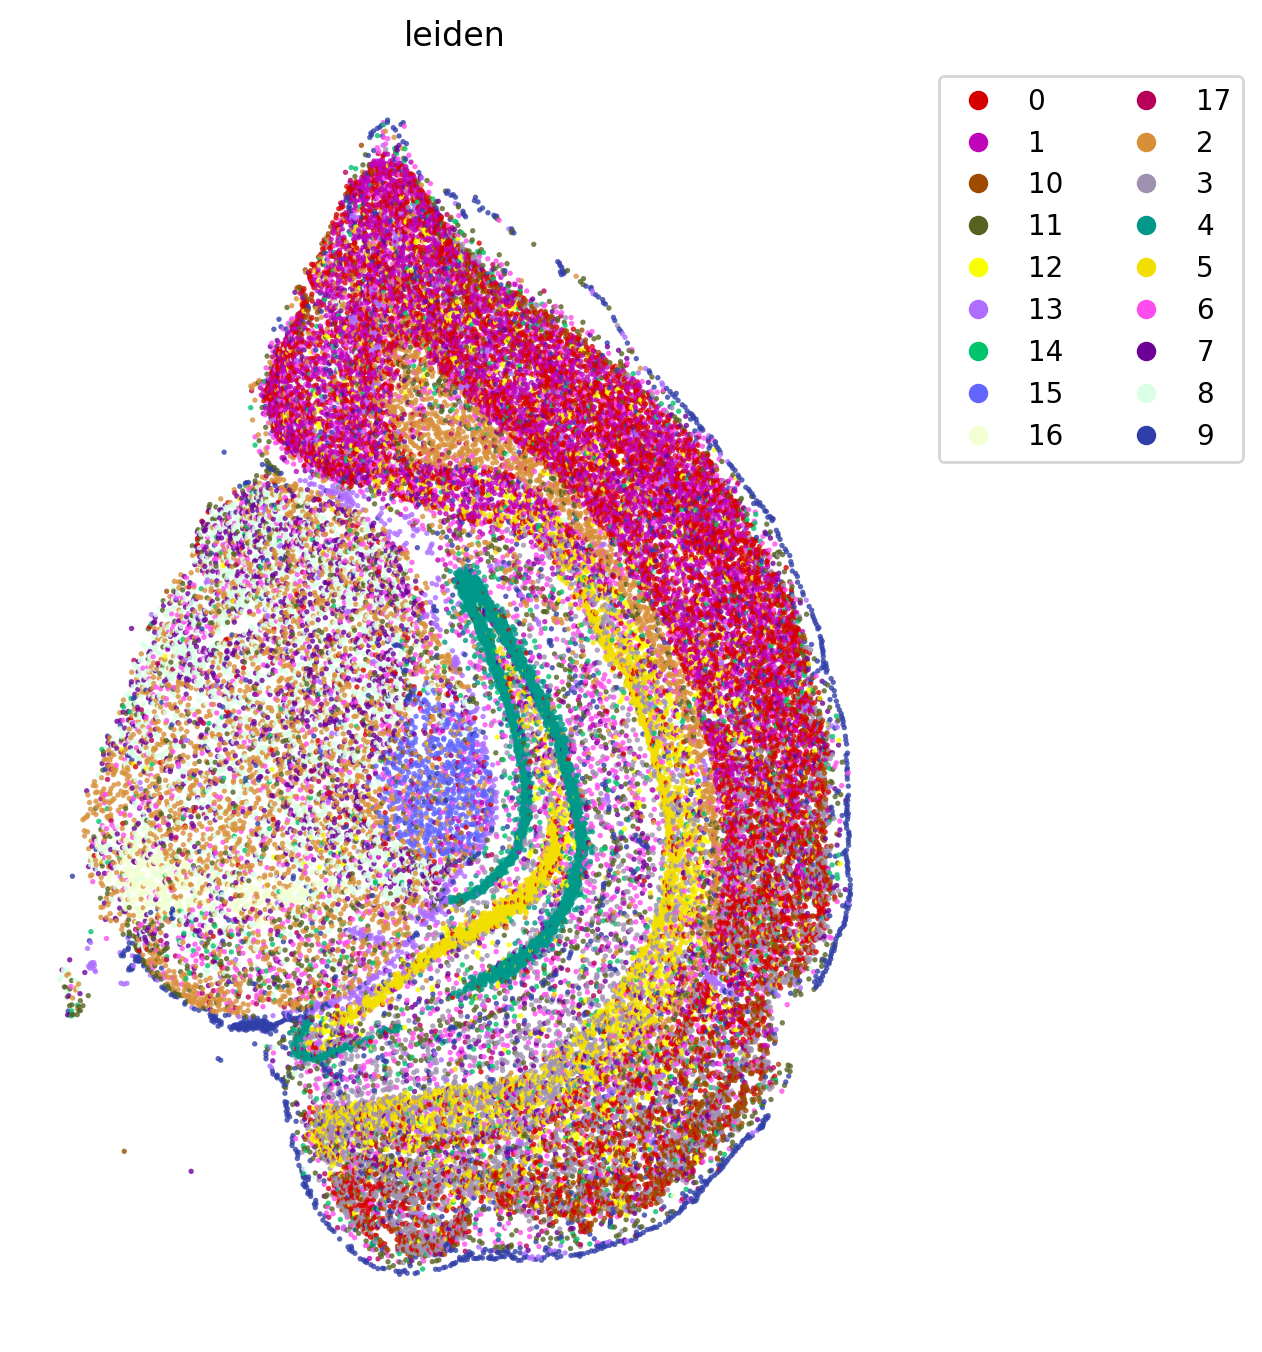

In [12]:
dyn.tl.leiden(adata, resolution=1)
st.pl.space(adata, color=['leiden'], pointsize=0.2, show_legend="upper left", cmap="tab20")

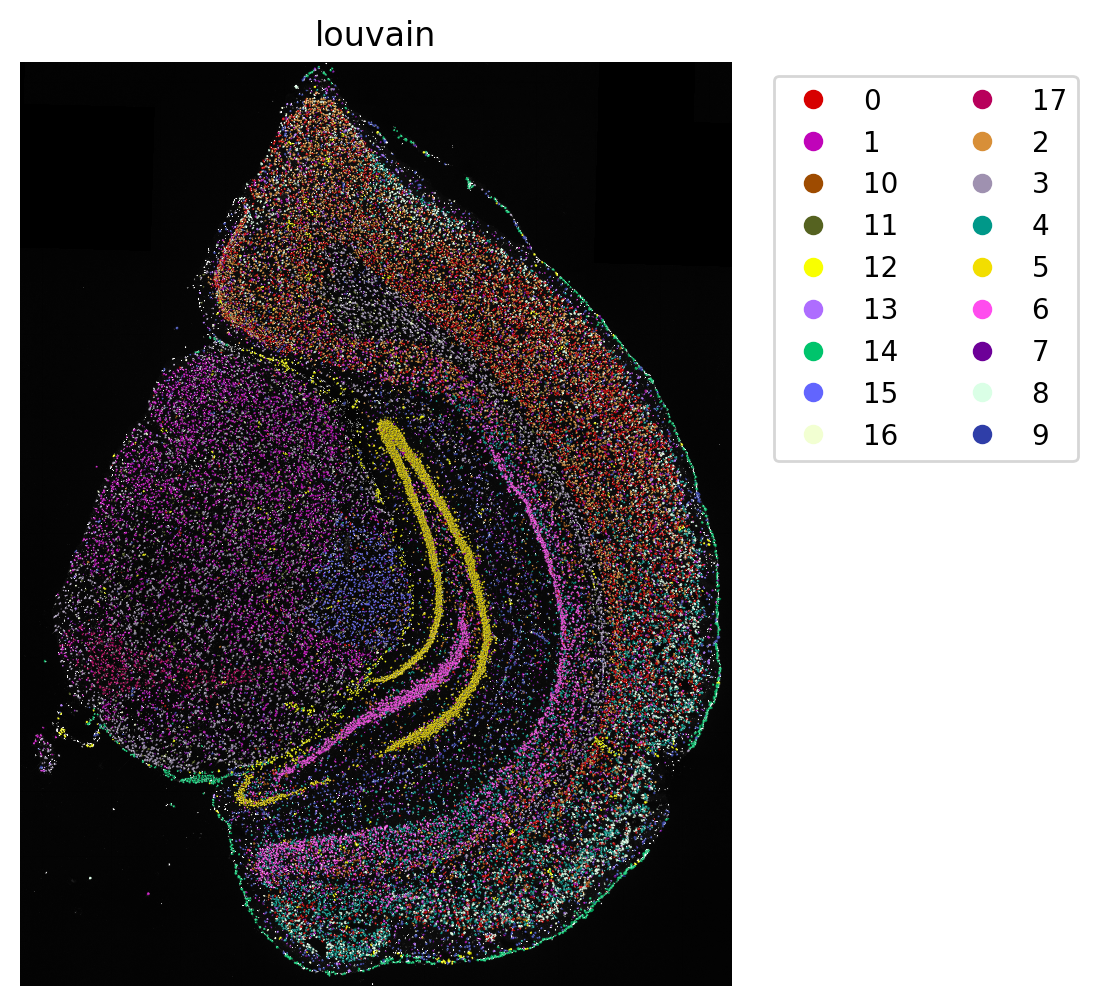

Saving figure to ./scatters_cell_label_louvain.pdf...
Done


In [28]:
#dyn.tl.louvain(adata, resolution=1)
st.pl.geo(adata, color=['louvain'], pointsize=0.2, boundary_width=0, show_legend="upper left", img_layers="mouse_brain", slices="ssdna")
st.pl.geo(adata, color=['louvain'], pointsize=0.2, boundary_width=0, show_legend="upper left", img_layers="mouse_brain", slices="ssdna",
            save_show_or_return='save', save_kwargs={"path":"cell_label_louvain", "ext":"pdf", "dpi":300, "width":1,"heigth":1})

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [120.9371s]


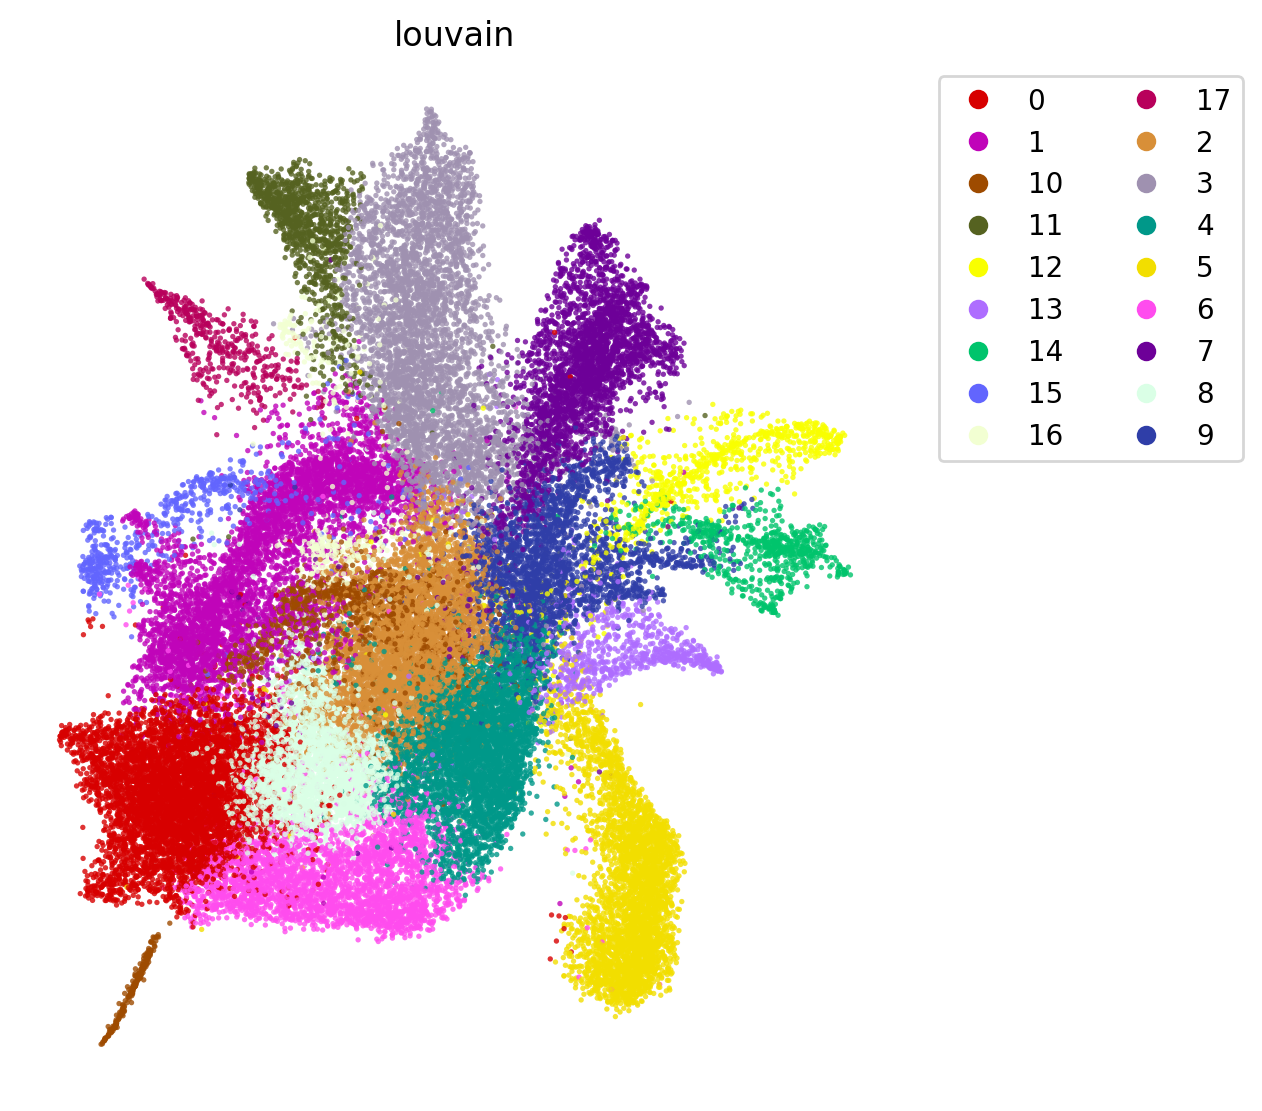

In [14]:
dyn.tl.reduceDimension(adata)
st.pl.space(adata, color=['louvain'], space="umap", pointsize=0.2, show_legend="upper left", cmap="tab20")

In [19]:
del adata.obsm['pearson_residuals']
del adata.obsm['X_umap']
del adata.uns['umap_fit']
adata

AnnData object with n_obs × n_vars = 46720 × 26274
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'louvain'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'spatial', 'pp', 'neighbors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors'
    obsm: 'bbox', 'contour', 'spatial', 'X_pca', 'X_spatial'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [29]:
adata.write("adata_cell_labels_cluster.h5ad", compression='gzip')

In [32]:
adata = anndata.read("adata_cell_labels_cluster.h5ad")